#### 新的分组标准 
效果不好： 2 11 12 13 16 19
效果好：1 8 9 15 17

In [26]:
library(Seurat)
library(ggplot2)
library(UCell)
library(patchwork)
library(tidyr)
library(dplyr)
library(RColorBrewer)
library(GeneNMF)
library(rhdf5)
library(SingleCellExperiment)
library(SummarizedExperiment)
library(GenomicRanges)
library(BiocGenerics)
library(generics)
library(Matrix)
library(scater)
library(data.table)

In [27]:
do_download <- FALSE

ddir <- "input"
data.path <- sprintf("%s/Tumor_combination_LY_CG.rds", ddir)

if (do_download) {
  dir.create(ddir)
  options(timeout = 3000)
  download.file("https://figshare.com/ndownloader/files/47742634", destfile = data.path)
}

seu <- readRDS(data.path)

In [28]:
Make_unique <- function(arr) {
  dep_arr <- list()
  dep_idx <- which(duplicated(arr))
  for (idx in dep_idx) {
    item <- arr[idx]
    if (!(item %in% attr(dep_arr, "names"))) {
      dep_arr[item] <- 1
    }
    count <- dep_arr[[item]]
    arr[idx] <- paste0(arr[idx], ".", count)
    dep_arr[[item]] <- dep_arr[[item]] + 1
  }
  return(arr)
}

Load_h5adsc_to_SCE <- function(scpath, raw = TRUE) {
  scmat <- h5read(scpath, "/")
  if (("Raw" %in% attr(scmat$layers, "names")) && raw) {
    cat("** Using raw data...\n")
    if (class(scmat$layers$Raw)[[1]] == "list") {
      cat("** Raw data is a sparse matrix...\n")
      dat <- sparseMatrix(
        i = scmat$layers$Raw$indices[] + 1,
        p = scmat$layers$Raw$indptr[],
        x = as.numeric(scmat$layers$Raw$data[]),
        repr = "C"
      )
    } else {
      cat("** Raw data is a dense matrix...\n")
      dat <- as(scmat$layers$Raw, "dgCMatrix")
    }
    h5ad.var <- scmat$var
  } else {
    cat("** Using processed data...\n")
    X <- scmat$X
    dat <- sparseMatrix(
      i = X$indices[] + 1,
      p = X$indptr[],
      x = as.numeric(X$data[]),
      repr = "C"
    )
    h5ad.var <- scmat$var
  }
  cat("** Core data loaded...\n")
  # generate factors using categories
  var <- list()
  if ("__categories" %in% attr(h5ad.var, "names")) { # old anndata
    for (name in attr(h5ad.var[["__categories"]], "names")) {
      if (length(h5ad.var[[name]]) >= length(h5ad.var[["__categories"]][[name]])) {
        var[[name]] <- factor(h5ad.var[[name]], labels = h5ad.var[["__categories"]][[name]])
      }
    }
  } else {
    for (name in attr(h5ad.var, "names")) {
      if (name != "_index") {
        if (class(var[[name]]) == "list") {
          var[[name]] <- factor(h5ad.var[[name]]$codes,
            labels = h5ad.var[[name]]$categories
          )
        } else {
          var[[name]] <- h5ad.var[[name]]
        }
      } else {
        var[[name]] <- h5ad.var[[name]]
      }
    }
  }
  cat("** Var loaded...\n")
  h5ad.obs <- scmat$obs
  obs <- list()
  if ("__categories" %in% attr(h5ad.obs, "names")) { # old anndata
    for (name in attr(h5ad.obs[["__categories"]], "names")) {
      if (length(h5ad.obs[[name]]) >= length(h5ad.obs[["__categories"]][[name]])) {
        obs[[name]] <- factor(h5ad.obs[[name]], labels = h5ad.obs[["__categories"]][[name]])
      }
    }
  } else { # new anndata
    for (name in attr(h5ad.obs, "names")) {
      if (name != "_index") {
        if (class(h5ad.obs[[name]]) == "list") {
          obs[[name]] <- factor(h5ad.obs[[name]]$codes,
            labels = h5ad.obs[[name]]$categories
          )
        } else {
          obs[[name]] <- h5ad.obs[[name]]
        }
      } else {
        obs[[name]] <- h5ad.obs[[name]]
      }
    }
  }
  # some datasets uses barcodes instead of `_index`
  if (!("_index" %in% attr(h5ad.obs, "names"))) {
    obs$`_index` <- obs$`barcodes`
  }
  obs$`_index` <- Make_unique(obs$`_index`)
  obs_use <- data.frame(
    annotation = obs$annotation,
    batch = obs$batch,
    treat = obs$treat,
    cnv_status = obs$cnv_status,
    cnv_score = obs$cnv_score,
    row.names = as.character(obs$`_index`)
  )
  cat("** Obs loaded...\n")
  dims <- c(length(h5ad.var[["_index"]]), length(obs$`_index`))
  dat@Dim <- dims
  dat@Dimnames <- list(
    as.character(h5ad.var[["_index"]]),
    as.character(obs$`_index`)
  )
  cat("** Dims loaded...\n")

  sce <- SingleCellExperiment(
    assays = list(counts = dat),
    rowData = DataFrame(data.frame(var[['_index']])),
    colData = DataFrame(data.frame(obs_use))
  )
  cat("** SCE constructed...\n")

  umap <- as.data.frame(t(scmat$obsm$X_umap))
  colnames(umap) <- c('UMAP-1', 'UMAP-2')
  rownames(umap) <- colnames(sce)
  reducedDim(sce, 'UMAP', withDimnames=TRUE) <- umap
  cat("** UMAP loaded...\n")
  return(sce)
}

In [29]:
sce <- Load_h5adsc_to_SCE("adata-epi-total.h5ad", raw = TRUE)

** Using processed data...
** Core data loaded...
** Var loaded...
** Obs loaded...
** Dims loaded...
** SCE constructed...
** UMAP loaded...


In [30]:
seu <- SeuratObject::as.Seurat(x = sce, counts = "counts", data = "counts")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP- to UMAP_”


In [31]:
seu.list.batch <- SplitObject(seu, split.by = "batch")

In [32]:
seu.Better <- list(  `1T` = seu.list.batch$`1T`,
                 `8T` = seu.list.batch$`8T`,
                 `9T` = seu.list.batch$`9T`,
                 `15T` = seu.list.batch$`15T`,
                 `17T` = seu.list.batch$`17T`
                 )

In [33]:
seu.Worse <- list(  
                 `2T` = seu.list.batch$`2T`,
                 `11T` = seu.list.batch$`11T`,
                 `12T` = seu.list.batch$`12T`,
                 `13T` = seu.list.batch$`13T`,
                 `16T` = seu.list.batch$`16T`,
                 `19T` = seu.list.batch$`19T`
                 )

In [34]:
seu.TNBC <- list(  `1T` = seu.list.batch$`1T`,
                `2T` = seu.list.batch$`2T`,
                 `8T` = seu.list.batch$`8T`,
                 `9T` = seu.list.batch$`9T`,
                 `16T` = seu.list.batch$`16T`
                 )

In [35]:
seu.TNBCBetter <- list(  
                `1T` = seu.list.batch$`1T`,
                 `9T` = seu.list.batch$`9T`
                 )

In [36]:
seu.TNBCWorse <- list(  
                 `2T` = seu.list.batch$`2T`,
                 `8T` = seu.list.batch$`8T`,
                 `16T` = seu.list.batch$`16T`
                 )

In [37]:
seu.LumB <- list(
                `11T` = seu.list.batch$`11T`,
                 `12T` = seu.list.batch$`12T`,
                 `13T` = seu.list.batch$`13T`,
                 `15T` = seu.list.batch$`16T`
                 )

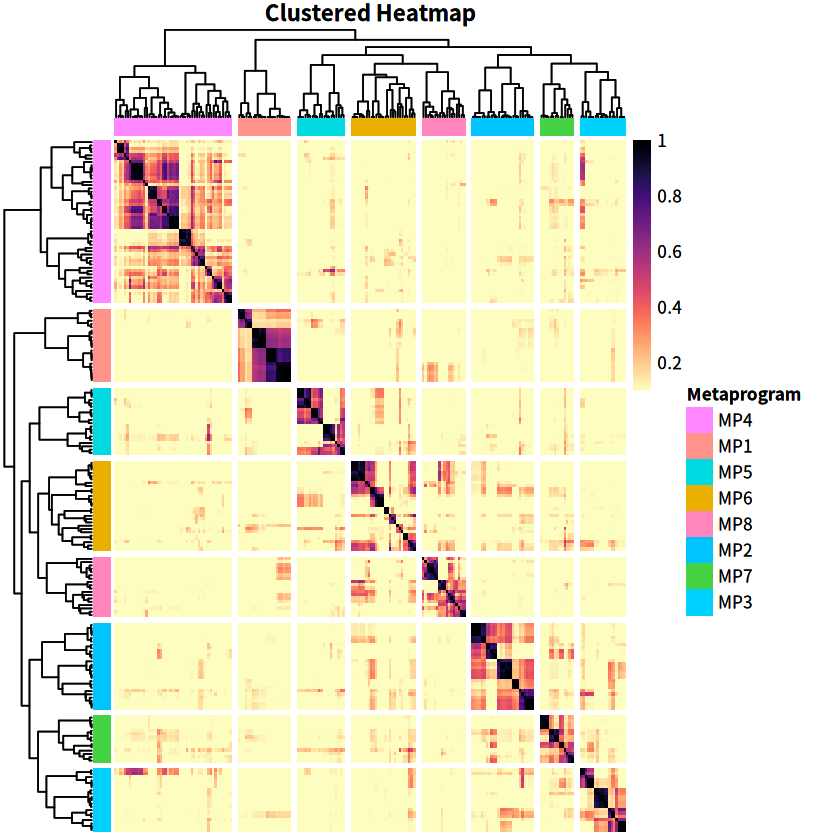

In [38]:
geneNMF.programs.Better <- multiNMF(seu.Better, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Better <- getMetaPrograms(geneNMF.programs.Better,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Better,
                       similarity.cutoff = c(0.1,1))
ph

In [39]:
svg(filename = "figures/BetterGeneSet-effect.svg",width = 7,height = 6.5)
ph
dev.off()

pdf 
  2

In [40]:
geneNMF.metaprograms.Better$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,0.8,0.4751193,0.527,10,22
MP2,0.8,0.2808306,0.379,9,26
MP3,0.8,0.2458215,0.351,10,19
MP4,0.8,0.2326500,0.301,16,49
MP5,0.6,0.3002664,0.366,4,20
MP6,0.6,0.1242784,0.255,2,27
MP7,0.4,0.3367429,0.414,12,14
MP8,0.2,0.2513567,0.345,16,18


In [41]:
top_p.Better <- lapply(geneNMF.metaprograms.Better$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

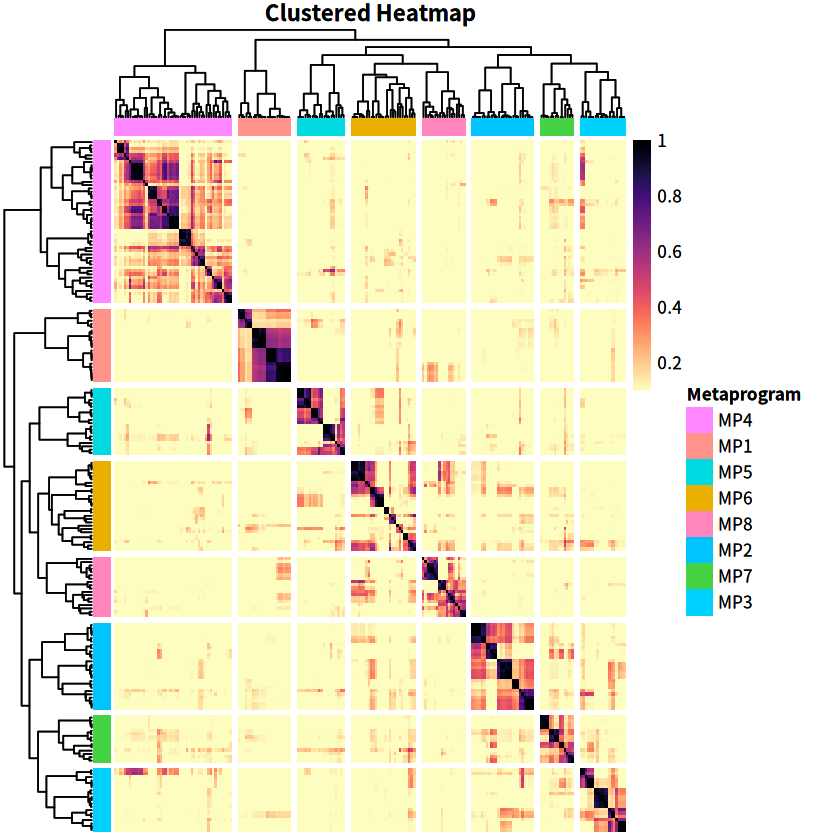

In [42]:
geneNMF.metaprograms.Better$metaprograms.genegeneNMF.programs.Better <- multiNMF(seu.Better, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Better <- getMetaPrograms(geneNMF.programs.Better,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Better,
                       similarity.cutoff = c(0.1,1))
ph

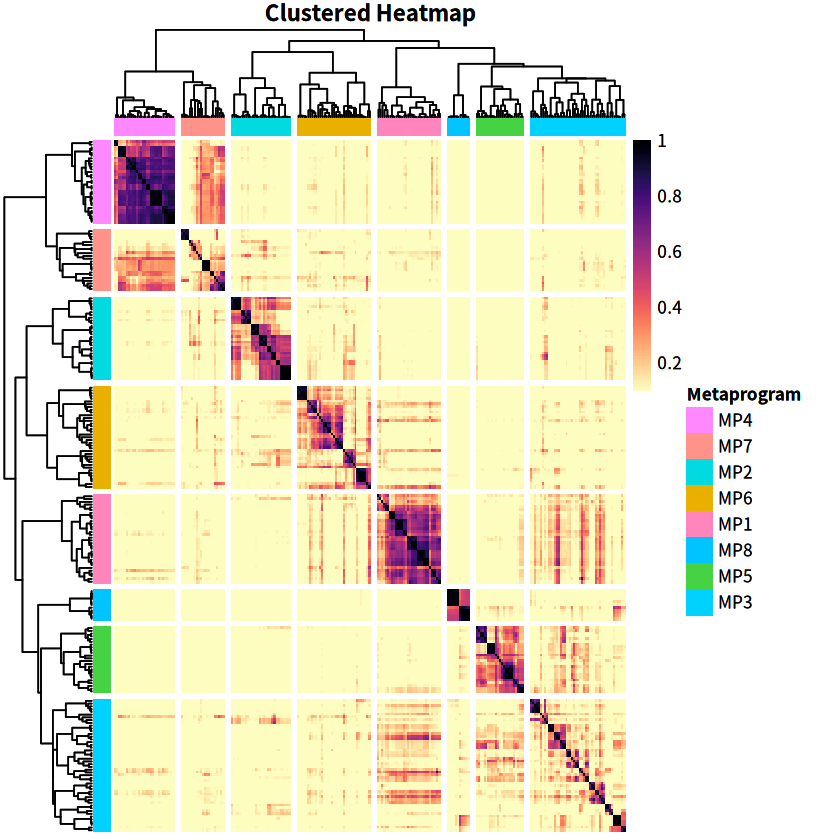

In [43]:
geneNMF.programs.Worse <- multiNMF(seu.Worse, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Worse <- getMetaPrograms(geneNMF.programs.Worse,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Worse,
                       similarity.cutoff = c(0.1,1))
ph

In [44]:
svg(filename = "figures/WorseGeneSet-effect.svg",width = 7,height = 6.5)
ph
dev.off()

pdf 
  2

In [45]:
geneNMF.metaprograms.Worse$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.0000000,0.46427274,0.550,26,32
MP2,1.0000000,0.36482331,0.425,18,30
MP3,1.0000000,-0.04613891,0.176,6,48
MP4,0.8333333,0.64350056,0.722,37,30
MP5,0.6666667,0.36268800,0.445,37,24
MP6,0.6666667,0.18981239,0.290,12,37
MP7,0.6666667,-0.01205556,0.231,5,22
MP8,0.3333333,0.67690631,0.703,6,11


In [46]:
top_p.Worse <- lapply(geneNMF.metaprograms.Worse$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})


In [47]:
geneNMF.metaprograms.Worse$metaprograms.genes

$MP1
 [1] "FOS"      "EGR1"     "JUN"      "JUNB"     "IER2"     "ZFP36"   
 [7] "SOCS3"    "DUSP1"    "FOSB"     "DNAJB1"   "CCNL1"    "GADD45B" 
[13] "EGR2"     "HES1"     "DDIT3"    "PPP1R15A" "KLF10"    "MYC"     
[19] "H2AX"     "SERTAD1"  "IER3"     "HSPA1B"   "NFKBIZ"   "RHOB"    
[25] "IRF1"     "MCL1"    

$MP2
 [1] "KRT15"   "KRT23"   "SLPI"    "GABRP"   "CCL28"   "MMP7"    "KIT"    
 [8] "RARRES1" "PIGR"    "LTF"     "KRT6B"   "SLC34A2" "MGP"     "NDRG2"  
[15] "KRT14"   "KRT17"   "JUN"     "FOLR1"  

$MP3
[1] "JUN"    "EGR1"   "JUNB"   "ZFP36"  "IER2"   "DNAJB1"

$MP4
 [1] "ACTA2"    "TAGLN"    "TPM2"     "MYLK"     "ECRG4"    "CXCL14"  
 [7] "MYL9"     "CNN1"     "MYH11"    "SYT8"     "ACTG2"    "PPP1R14A"
[13] "POSTN"    "KRT14"    "DKK3"     "MATN2"    "APOE"     "COL17A1" 
[19] "A2M"      "SPARCL1"  "MIR205HG" "KCNMB1"   "TGFB1I1"  "TP63"    
[25] "KRT17"    "LMOD1"    "TSHZ2"    "MSRB3"    "OXTR"     "PDLIM7"  
[31] "COL14A1"  "PDGFA"    "LTBP2"    "FGF1"     "CARMN"    "ADAMTS5" 
[37] "EGR1"    

$MP5
 [1] "TFF1"     "ANKRD30A" "TFF3"     "STC2"     "SCUBE2"   "AGR2"    
 [7] "TCIM"     "FBP1"     "AGR3"     "PDK4"     "DCDC2"    "SYTL2"   
[13] "PLAT"     "AFF3"     "LRP2"     "BATF"     "ERBB4"    "AK5"     
[19] "SLC40A1"  "GDF15"    "AREG"     "VSIG10L2" "AZGP1"    "C15orf48"
[25] "NEK10"    "VSIG2"    "INPP4B"   "ACADSB"   "EFHD1"    "DHCR24"  
[31] "MGP"      "XBP1"     "ST8SIA6"  "UCP2"     "MAGED2"   "TGM2"    
[37] "JUN"     

$MP6
 [1] "HLA-DRB1" "IFI27"    "HLA-DPA1" "HLA-DRA"  "CD74"     "HLA-DQB1"
 [7] "HLA-DPB1" "PLAAT4"   "PSMB9"    "LAP3"     "TAP1"     "UBE2L6"  

$MP7
[1] "TAGLN" "KRT17" "MYLK"  "MYL9"  "TPM2" 

$MP8
[1] "MUCL1"    "SERPINA1" "PIP"      "ALDH3B2"  "NUDT8"    "LRG1"

#### 
仅在Better组出现：SOCS3 CCNL1 EGR2 HES1 KLF10 MYC H2AX SERTAD1 TER3 NFKBIZ IRF1 MCL1

Dropped 1 empty meta-programs



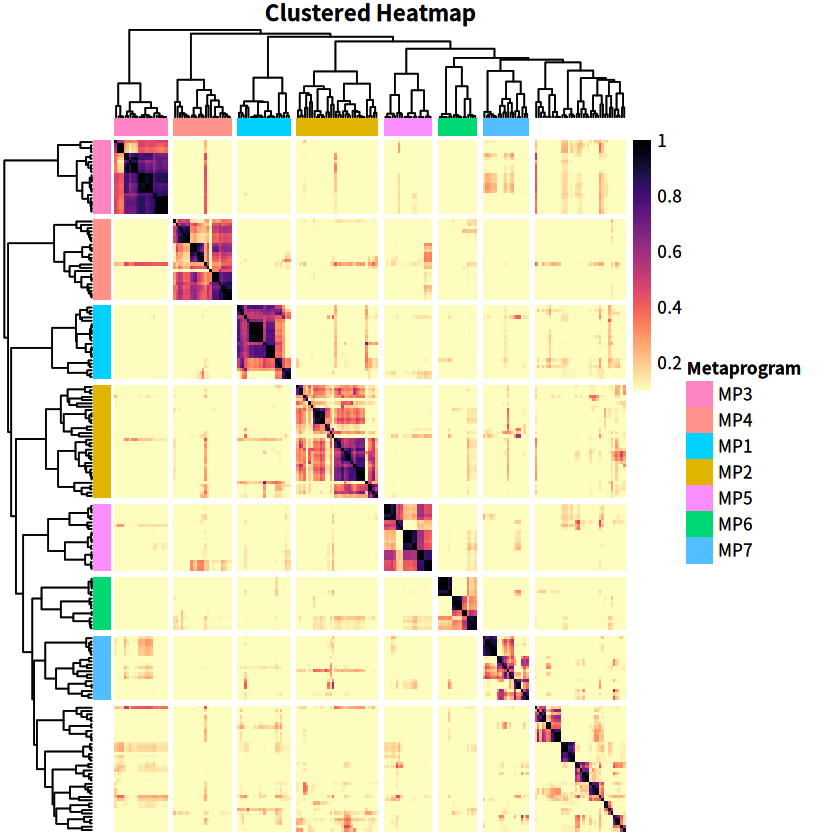

In [48]:
geneNMF.programs.TNBC <- multiNMF(seu.TNBC, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.TNBC <- getMetaPrograms(geneNMF.programs.TNBC,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.TNBC,
                       similarity.cutoff = c(0.1,1))
ph

In [49]:
geneNMF.metaprograms.TNBC$metaprograms.genes

$MP1
 [1] "CENPF"    "UBE2C"    "BIRC5"    "MAD2L1"   "FOXM1"    "MKI67"   
 [7] "TPX2"     "TOP2A"    "PTTG1"    "CDCA3"    "TK1"      "UBE2T"   
[13] "CDK1"     "MYBL2"    "RAD51AP1" "CCNB2"    "CDC20"    "CCNA2"   
[19] "ASPM"     "RRM2"     "TYMS"     "TACC3"    "PLK1"     "ZWINT"   
[25] "CENPW"    "CENPN"   

$MP2
 [1] "FOS"      "EGR1"     "IER2"     "FOSB"     "JUN"      "JUNB"    
 [7] "DUSP1"    "ATF3"     "DNAJB1"   "NR4A1"    "CCNL1"    "GADD45B" 
[13] "HSPA1B"   "PPP1R15A"

$MP3
 [1] "TAGLN"    "ACTA2"    "MYLK"     "TPM2"     "MYL9"     "ECRG4"   
 [7] "SPARCL1"  "A2M"      "MYH11"    "CNN1"     "KRT14"    "KRT17"   
[13] "SNCG"     "LTBP2"    "COL17A1"  "DST"      "TSHZ2"    "FBXO32"  
[19] "LBH"      "MXRA8"    "NNMT"     "MAOB"     "PDLIM7"   "NES"     
[25] "SERPING1"

$MP4
 [1] "AGR2"     "ANKRD30A" "STC2"     "TFF1"     "AGR3"     "TFF3"    
 [7] "AZGP1"    "TCIM"     "AFF3"     "PLAT"     "SYTL2"    "SCUBE2"  
[13] "SLC40A1"  "FBP1"     "DCDC2"    "FOXA1"    "TM4SF18"  "EFHD1"   
[19] "ESR1"     "INPP4B"   "MLPH"     "AK5"      "MAGED2"   "GALNT6"  
[25] "DNAJC12"  "TMC5"     "ACADSB"   "SPDEF"    "ST8SIA6"  "ADIRF"   
[31] "FAM3B"    "LRP2"     "XBP1"     "MGP"      "DEGS2"    "TBC1D9"  
[37] "SLC39A6"  "PIP"     

$MP5
 [1] "KRT23"   "SCGB2A2" "PIGR"    "CCL28"   "LTF"     "SCGB1D2" "ANPEP"  
 [8] "SNORC"   "SLPI"    "PTN"     "S100A9"  "BBOX1"   "NDRG2"   "FOSB"   
[15] "RGS2"    "FDCSP"   "LCN2"    "TSHZ2"   "NCALD"  

$MP6
[1] "S100A8" "CLU"   

$MP7
[1] "CXCL14"   "LY6D"     "WNT4"     "CTNNBIP1" "ATF3"

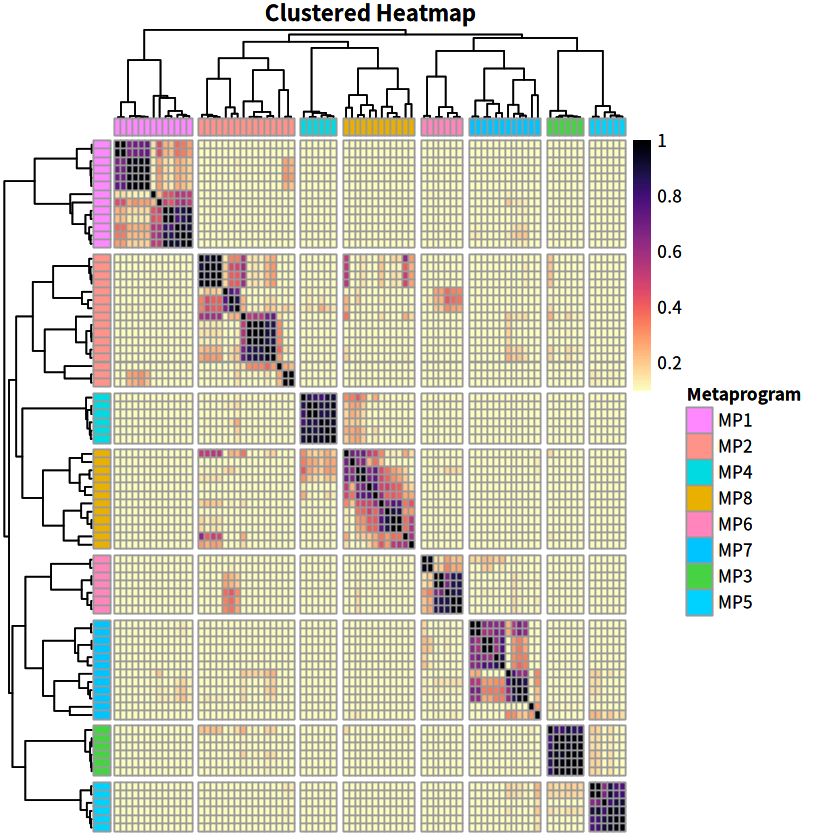

In [50]:
geneNMF.programs.TNBCBetter <- multiNMF(seu.TNBCBetter, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.TNBCBetter <- getMetaPrograms(geneNMF.programs.TNBCBetter,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.TNBCBetter,
                       similarity.cutoff = c(0.1,1))
ph

In [51]:
geneNMF.metaprograms.Better$metaprograms.genes

$MP1
 [1] "TAGLN"  "ACTA2"  "TPM2"   "MYL9"   "MYLK"   "VIM"    "ACTG2"  "FBXO32"
 [9] "KRT17"  "NNMT"  

$MP2
[1] "SCGB2A2" "PIGR"    "SNORC"   "SCGB1D2" "SAA2"    "NDRG2"   "SCGB3A1"
[8] "CD74"    "ZFP36"  

$MP3
 [1] "MGP"      "AGR2"     "STC2"     "ANKRD30A" "AGR3"     "TCIM"    
 [7] "TFF3"     "DCDC2"    "PI15"     "INPP4B"  

$MP4
 [1] "EGR1"     "JUN"      "ATF3"     "FOSB"     "DUSP1"    "NR4A1"   
 [7] "FOS"      "IER2"     "NEAT1"    "JUNB"     "DNAJB1"   "KLF6"    
[13] "PPP1R15A" "HSPA1B"   "RHOB"     "NR4A2"   

$MP5
[1] "CALML5" "TYMS"   "DNAJB1" "H2AZ1" 

$MP6
[1] "S100A8" "S100A9"

$MP7
 [1] "APOD"       "DHRS2"      "SCGB3A1"    "ALOX15B"    "PIP"       
 [6] "ALDH3B2"    "AC093001.1" "MUCL1"      "AQP3"       "LTF"       
[11] "AGR2"       "SCP2"      

$MP8
 [1] "CXCL14"   "CASP14"   "KRT5"     "CTNNBIP1" "TGFBI"    "IFI27"   
 [7] "PKP1"     "LY6D"     "IGFBP5"   "RORA"     "NRARP"    "LGALSL"  
[13] "MEF2A"    "ID1"      "LGALS3"   "S100A10"

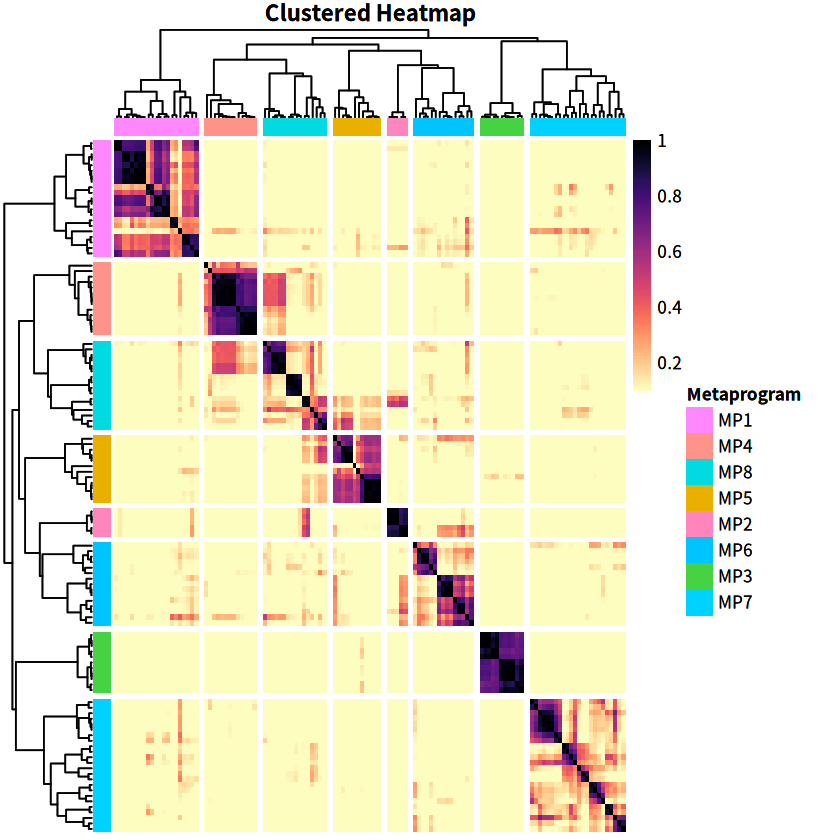

In [52]:
geneNMF.programs.TNBCWorse <- multiNMF(seu.TNBCWorse, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.TNBCWorse <- getMetaPrograms(geneNMF.programs.TNBCWorse,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.TNBCWorse,
                       similarity.cutoff = c(0.1,1))
ph

In [53]:
geneNMF.metaprograms.Worse$metaprograms.genes

$MP1
 [1] "FOS"      "EGR1"     "JUN"      "JUNB"     "IER2"     "ZFP36"   
 [7] "SOCS3"    "DUSP1"    "FOSB"     "DNAJB1"   "CCNL1"    "GADD45B" 
[13] "EGR2"     "HES1"     "DDIT3"    "PPP1R15A" "KLF10"    "MYC"     
[19] "H2AX"     "SERTAD1"  "IER3"     "HSPA1B"   "NFKBIZ"   "RHOB"    
[25] "IRF1"     "MCL1"    

$MP2
 [1] "KRT15"   "KRT23"   "SLPI"    "GABRP"   "CCL28"   "MMP7"    "KIT"    
 [8] "RARRES1" "PIGR"    "LTF"     "KRT6B"   "SLC34A2" "MGP"     "NDRG2"  
[15] "KRT14"   "KRT17"   "JUN"     "FOLR1"  

$MP3
[1] "JUN"    "EGR1"   "JUNB"   "ZFP36"  "IER2"   "DNAJB1"

$MP4
 [1] "ACTA2"    "TAGLN"    "TPM2"     "MYLK"     "ECRG4"    "CXCL14"  
 [7] "MYL9"     "CNN1"     "MYH11"    "SYT8"     "ACTG2"    "PPP1R14A"
[13] "POSTN"    "KRT14"    "DKK3"     "MATN2"    "APOE"     "COL17A1" 
[19] "A2M"      "SPARCL1"  "MIR205HG" "KCNMB1"   "TGFB1I1"  "TP63"    
[25] "KRT17"    "LMOD1"    "TSHZ2"    "MSRB3"    "OXTR"     "PDLIM7"  
[31] "COL14A1"  "PDGFA"    "LTBP2"    "FGF1"     "CARMN"    "ADAMTS5" 
[37] "EGR1"    

$MP5
 [1] "TFF1"     "ANKRD30A" "TFF3"     "STC2"     "SCUBE2"   "AGR2"    
 [7] "TCIM"     "FBP1"     "AGR3"     "PDK4"     "DCDC2"    "SYTL2"   
[13] "PLAT"     "AFF3"     "LRP2"     "BATF"     "ERBB4"    "AK5"     
[19] "SLC40A1"  "GDF15"    "AREG"     "VSIG10L2" "AZGP1"    "C15orf48"
[25] "NEK10"    "VSIG2"    "INPP4B"   "ACADSB"   "EFHD1"    "DHCR24"  
[31] "MGP"      "XBP1"     "ST8SIA6"  "UCP2"     "MAGED2"   "TGM2"    
[37] "JUN"     

$MP6
 [1] "HLA-DRB1" "IFI27"    "HLA-DPA1" "HLA-DRA"  "CD74"     "HLA-DQB1"
 [7] "HLA-DPB1" "PLAAT4"   "PSMB9"    "LAP3"     "TAP1"     "UBE2L6"  

$MP7
[1] "TAGLN" "KRT17" "MYLK"  "MYL9"  "TPM2" 

$MP8
[1] "MUCL1"    "SERPINA1" "PIP"      "ALDH3B2"  "NUDT8"    "LRG1"

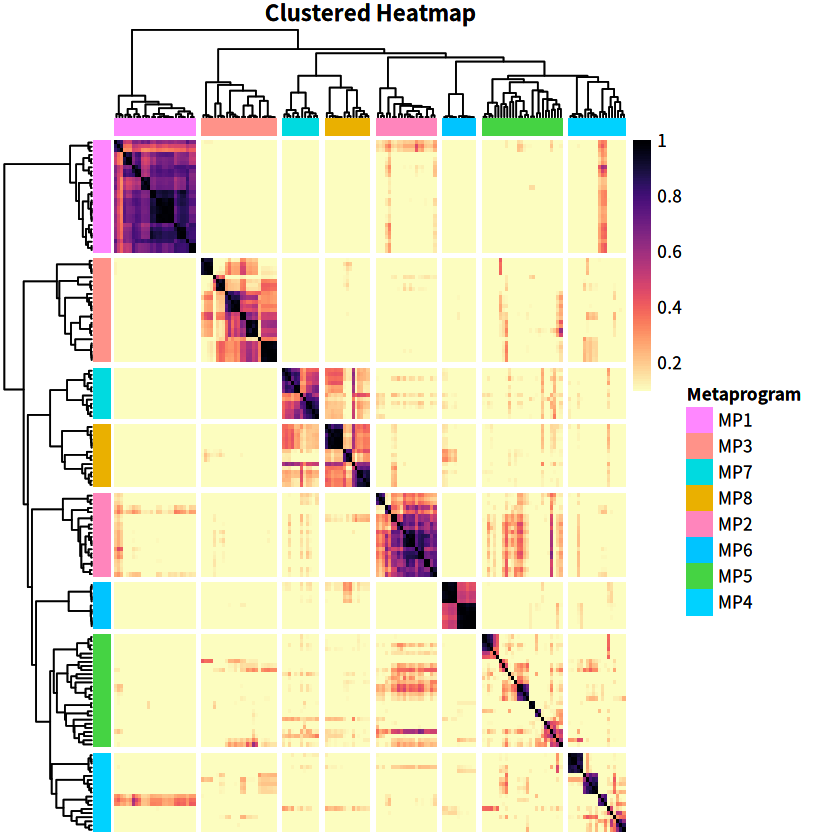

In [54]:
geneNMF.programs.LumB <- multiNMF(seu.LumB, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.LumB <- getMetaPrograms(geneNMF.programs.LumB,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.LumB,
                       similarity.cutoff = c(0.1,1))
ph

In [55]:
geneNMF.metaprograms.LumB$metaprograms.genes

$MP1
 [1] "ACTA2"    "TPM2"     "TAGLN"    "MYLK"     "ECRG4"    "CXCL14"  
 [7] "MYL9"     "CNN1"     "MYH11"    "SYT8"     "PPP1R14A" "DKK3"    
[13] "MATN2"    "COL17A1"  "KRT14"    "ACTG2"    "A2M"      "APOE"    
[19] "SPARCL1"  "TGFB1I1"  "MIR205HG" "TP63"     "KCNMB1"   "CARMN"   
[25] "MME"      "LTBP2"    "LMOD1"    "MSRB3"    "OXTR"     "PDLIM7"  
[31] "TNS4"     "FGF1"     "KRT17"    "SNCG"     "PDGFA"    "ADAMTS5" 
[37] "TSHZ2"    "CCDC8"    "DST"      "HTRA1"    "GYPC"     "LIMS2"   
[43] "OSR1"     "ITGBL1"   "EDIL3"    "FAM126A"  "KIRREL1" 

$MP2
 [1] "FOS"        "EGR1"       "JUN"        "SOCS3"      "IER2"      
 [6] "JUNB"       "HES1"       "FOSB"       "ZFP36"      "DNAJB1"    
[11] "GADD45B"    "DUSP1"      "BTG2"       "ATF3"       "CCNL1"     
[16] "PPP1R15A"   "EGR2"       "DDIT3"      "RHOB"       "CSRNP1"    
[21] "IRF1"       "H2AX"       "AC011446.2" "RGS16"     

$MP3
 [1] "KRT15"   "SNORC"   "CCL28"   "GABRP"   "LTF"     "SLPI"    "KRT23"  
 [8] "PIGR"    "KIT"     "SLC34A2" "PROM1"   "TTYH1"   "NDRG2"   "LCN2"   

$MP4
[1] "IFI27" "PSMB9"

$MP5
 [1] "JUN"    "IER2"   "ZFP36"  "DNAJB1" "EGR1"   "FOS"    "JUNB"   "ATF3"  
 [9] "BTG2"   "CCNL1" 

$MP6
[1] "MUCL1"    "SERPINA1" "PIP"      "ALDH3B2"  "HMGCS2"   "SPINK8"   "NUDT8"   

$MP7
 [1] "TFF1"     "PLAT"     "HSPB8"    "KCNK6"    "PIP"      "MIDEAS"  
 [7] "TFF3"     "VSIG10L2" "HES4"     "C15orf48" "AFF3"     "C3orf52" 
[13] "BTG2"     "TM4SF1"   "TMEM176A" "MGP"      "BATF"     "CDKN1A"  
[19] "IER2"     "KIAA0040" "CASP7"    "SLC39A6"  "CPE"      "FASN"    
[25] "CRABP2"   "IL20RA"   "NR4A1"    "TSPAN5"   "CST3"     "NQO1"    
[31] "TMSB4X"   "ALAS1"    "CYB5A"   

$MP8
 [1] "PDK4"     "ANKRD30A" "SYTL2"    "AGR2"     "STC2"     "SCUBE2"  
 [7] "SLC7A2"   "TMC5"     "TFF1"     "SLC40A1"  "AGR3"     "FBP1"    
[13] "AFF3"     "PIP"      "TFF3"     "AK5"      "ERBB4"    "LRP2"    
[19] "BATF"     "ESR1"     "INPP4B"   "VSIG10L2" "DCDC2"    "ADAM10"  
[25] "AR"       "ACADSB"   "EMP1"     "CA12"     "CMAHP"    "PLAT"    
[31] "AZGP1"    "VSIG2"    "EFHD1"    "DHCR24"   "NEK10"    "DNAJC12" 
[37] "RASEF"    "MAGED2"   "NRIP1"    "XBP1"     "LIN7A"    "TBX3"    
[43] "HSPB8"    "JUN"      "MGP"      "RELL1"

In [56]:
seu.Worse <- subset(seu, subset = batch %in% c("2T", "11T", "12T", "13T" , "16T", "19T"))

In [57]:
seu.Better <- subset(seu, subset = batch %in% c("1T", "8T" , "9T", "15T", "17T"))

In [58]:
seu.All <- subset(seu, subset = batch %in% c("1T", "8T" , "9T", "15T", "17T", "2T", "11T", "12T", "13T" , "16T", "19T"))

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


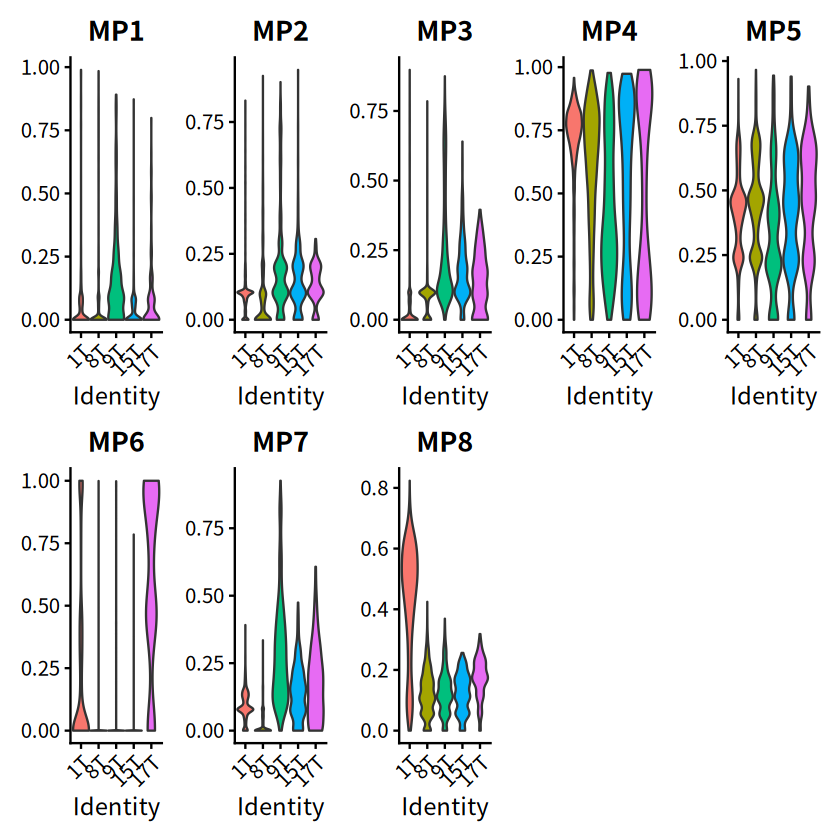

In [59]:
mp.genes <- geneNMF.metaprograms.Better$metaprograms.genes
seu.Better <- AddModuleScore_UCell(seu.Better, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Better, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)
        

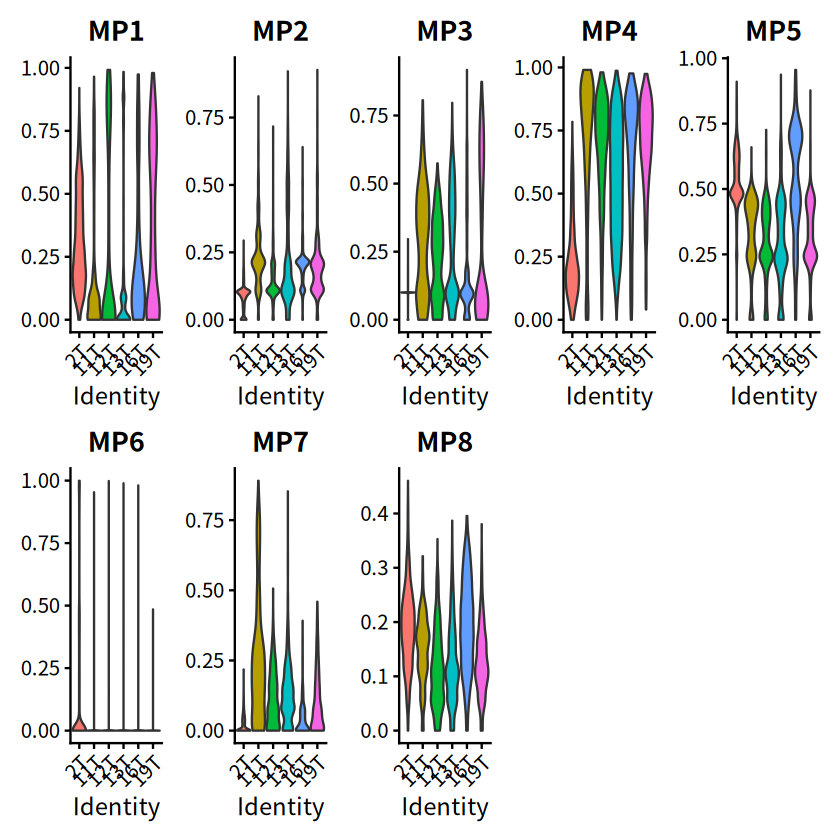

In [60]:
mp.genes <- geneNMF.metaprograms.Better$metaprograms.genes
seu.Worse <- AddModuleScore_UCell(seu.Worse, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Worse, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

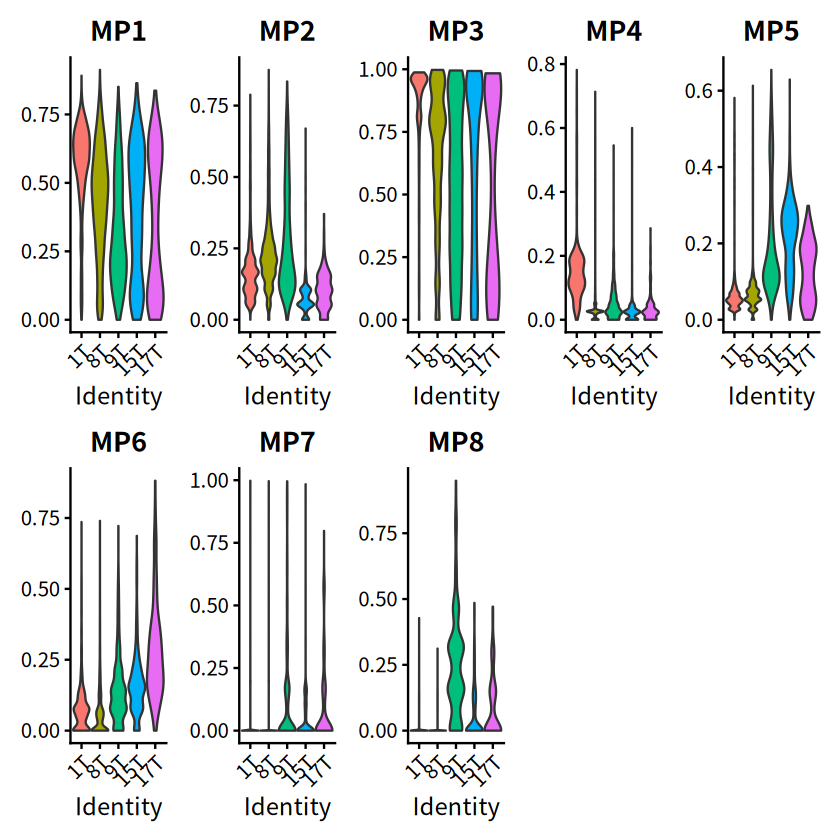

In [61]:
mp.genes <- geneNMF.metaprograms.Worse$metaprograms.genes
seu.Better <- AddModuleScore_UCell(seu.Better, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Better, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

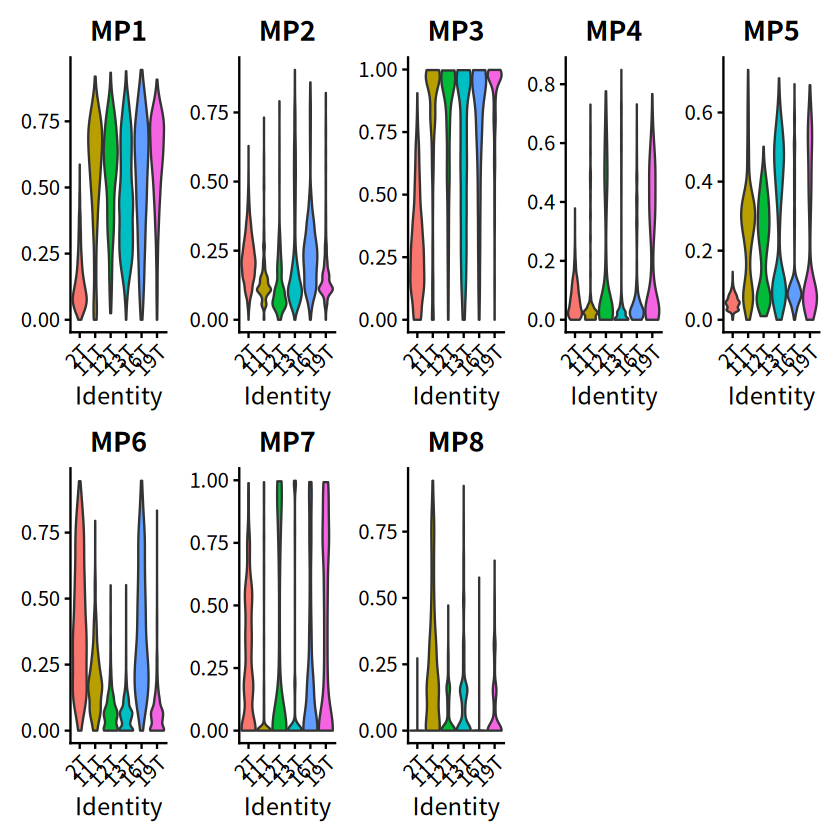

In [62]:
mp.genes <- geneNMF.metaprograms.Worse$metaprograms.genes
seu.Worse <- AddModuleScore_UCell(seu.Worse, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Worse, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)